<a href="https://colab.research.google.com/github/syoung7388/NlpBasicModel/blob/main/5_Seq2Seq_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Attention**

**[Overview]**
1. 라이브러리 설정 
2. HyperParameter 설정 
3. GPU 설정 
4. Data 준비(Data 불러오기, Tokenizing)
5. 모델 설계(Encoder, Decoder, Seq2Seq)
6. 모델 훈련 (Training)
7. 모델 검증 (Testing)

In [39]:
! pip install transformers==4.4.1
! pip install tokenizers==0.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**1.  라이브러리**

In [40]:
import os 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.nn.utils import clip_grad_norm_
import spacy
import random 
from tqdm.notebook import tqdm
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tokenizers import BertWordPieceTokenizer
from torch.utils.data import DataLoader, Dataset 
print(f'Pytorch version: {torch.__version__}')

Pytorch version: 1.12.1+cu113


**2.HyperParameter**

In [41]:
batch_size = 64
lr = 1e-4
epochs = 10
embedding_size =3
num_layers = 5
hidden_size = 256
dropout = 0.1
max_len = 30
vocab_size = 5000

#seed
seed=2891
torch.manual_seed = seed 

**3. GPU 설정**

In [42]:
! nvidia-smi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Thu Oct  6 04:58:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |   1772MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**4.Data 준비**

* Data 불러오기

In [43]:
train_data = pd.read_csv("https://raw.githubusercontent.com/syoung7388/Dataset/main/machinetranslation/mt_train.csv").dropna()
test_data = pd.read_csv("https://raw.githubusercontent.com/syoung7388/Dataset/main/machinetranslation/mt_test.csv").dropna()

train_src, train_trg  = train_data.iloc[:, 1], train_data.iloc[:, 2]
test_src, test_trg  = test_data.iloc[:, 1], test_data.iloc[:, 2]

print("=====================SRC=====================")
print(train_src)
print("=====================TRG=====================")
print(train_trg)

=====================SRC=====================
0        오븐 세척제에 포함된 피부 부식성/자극성 물질은 모두 심한 눈손상성/눈 자극성에도 ...
1        국내에서는 2030년 BAU 대비 37%의 온실가스 감축을 의무화함으로써 이에 따른...
2        수술 전 정맥혈을 채취하고 월경주기의 난포기 동안 8시간 이상 금식한 후 정맥혈액을...
3                   3등급 이하 인정자는 8.2%만이 재가급여에서 시설급여로 변경하였다.
4                  센싱에 의해 공기 중 오일입자가 기준치이하인지 여부를 판단할 수 있다.
                               ...                        
49995    광원부(1b)는 표시 패널(1a)의 일측에 배치되어 특정 파장을 갖는 광을 표시 패...
49996    상기 팽창밸브(45)는 상기 서브 컨덴서(44)를 통과한 냉매를 공급받아 팽창시키게...
49997    본 연구에서는 erythromycin 항생제에 대한 감수성이 33.3%로 다른 연구...
49998    특히, BNT계 무연 압전 세라믹 소 재는 충분한 소성 밀도를 얻기 위해서는 1,1...
49999    연골 척수종은 상피와 중간엽 성분이 혼합된 피부 부속기 종양으로 혼합 종양으로 알려...
Name: source, Length: 50000, dtype: object
=====================TRG=====================
0        All skin corrosion/irritation substances conta...
1        In Korea, it really is urgent to produce an an...
2        Before the operation, blood samples were obtai...
3        Only 8.2% of third graders or 

* Tokenizing 

In [44]:
def get_tokenizer(data, name):

    print(f"======== {name} ========")
    with open(f'{name}.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(data))

    #tokenizer 불러오기
    tokenizer = BertWordPieceTokenizer(lowercase=True)
    tokenizer.enable_truncation(max_length = max_len-2)
    tokenizer.enable_padding(pad_id=0, pad_token="[PAD]", direction="right", length =max_len-2)

    #tokenizer train 
    user_defined_symbols = ['[PAD]', '[UNK]', '[BOS]','[EOS]' ]
    corpus_file = [f'{name}.txt']
    output_path= f'hugging_{name}'
    min_frequency = 5
    tokenizer.train(files = corpus_file, vocab_size = vocab_size, min_frequency = min_frequency, show_progress=True, limit_alphabet =6000, special_tokens = user_defined_symbols)
    
    output = tokenizer.encode(data[0]) 

    print("sentence:", data[0])
    print("ids:", output.ids)
    print("max_len:", len(output.ids))
    print("tokens:", output.tokens)
    print("decode:", tokenizer.decode(output.ids))
    print("attention_mask:", output.attention_mask)
    print()

    return tokenizer


src_tokenizer = get_tokenizer(train_src, "SRC")
trg_tokenizer = get_tokenizer(train_trg, "TRC")

print("======== Special_Tokens ========")
pad, unk, bos, eos = src_tokenizer.encode("[PAD]").ids[:1], src_tokenizer.encode("[UNK]").ids[:1], src_tokenizer.encode("[BOS]").ids[:1], src_tokenizer.encode("[EOS]").ids[:1]
print("[PAD]:", pad)
print("[UNK]:", unk)
print("[BOS]:", bos)
print("[EOS]:", eos)

src_vocab_size = len(src_tokenizer.get_vocab())
trg_vocab_size = len(trg_tokenizer.get_vocab())

======== SRC ========
sentence: 오븐 세척제에 포함된 피부 부식성/자극성 물질은 모두 심한 눈손상성/눈 자극성에도 해당된다.
ids: [3167, 285, 4344, 3592, 2119, 1591, 617, 682, 476, 16, 2525, 476, 1191, 466, 1266, 4466, 2616, 2896, 507, 476, 16, 2616, 2525, 1961, 483, 1600, 625, 15]
max_len: 28
tokens: ['오브', '##ᆫ', '세척', '##제에', '포함된', '피부', '부', '##식', '##성', '/', '자극', '##성', '물질', '##은', '모두', '심한', '눈', '##손', '##상', '##성', '/', '눈', '자극', '##성에', '##도', '해당', '##된다', '.']
decode: 오븐 세척제에 포함된 피부 부식성 / 자극성 물질은 모두 심한 눈손상성 / 눈 자극성에도 해당된다.
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

======== TRC ========
sentence: All skin corrosion/irritation substances contained in oven cleaners are also subject to severe eye damage/eye irritation.
ids: [766, 1946, 674, 956, 413, 17, 3026, 2922, 3560, 4589, 308, 4330, 305, 3074, 703, 408, 701, 1172, 325, 2164, 3184, 

* Dataset, Dataloader 준비 

In [45]:


class MyDataset(Dataset):
    def __init__(self, datas, labels, src_tokenizer= src_tokenizer, trg_tokenizer=trg_tokenizer):
        self.datas = [bos+src_tokenizer.encode(data).ids+eos for data in datas]
        self.labels = [bos+trg_tokenizer.encode(label).ids+eos for label in labels]

    def __getitem__(self, idx):
        return torch.tensor(self.datas[idx]), torch.tensor(self.labels[idx])
    def __len__(self):
        return len(self.labels)


train_dataset = MyDataset(train_src, train_trg)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)


test_dataset = MyDataset(test_src, test_trg)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)


print(f"[Dataset] train: {len(train_dataset)}, test: {len(test_dataset)}")
print(f"[DataLoader] train: {len(train_dataloader)}, test: {len(test_dataloader)}")

[Dataset] train: 50000, test: 10000
[DataLoader] train: 782, test: 157


**5. Model 설계**

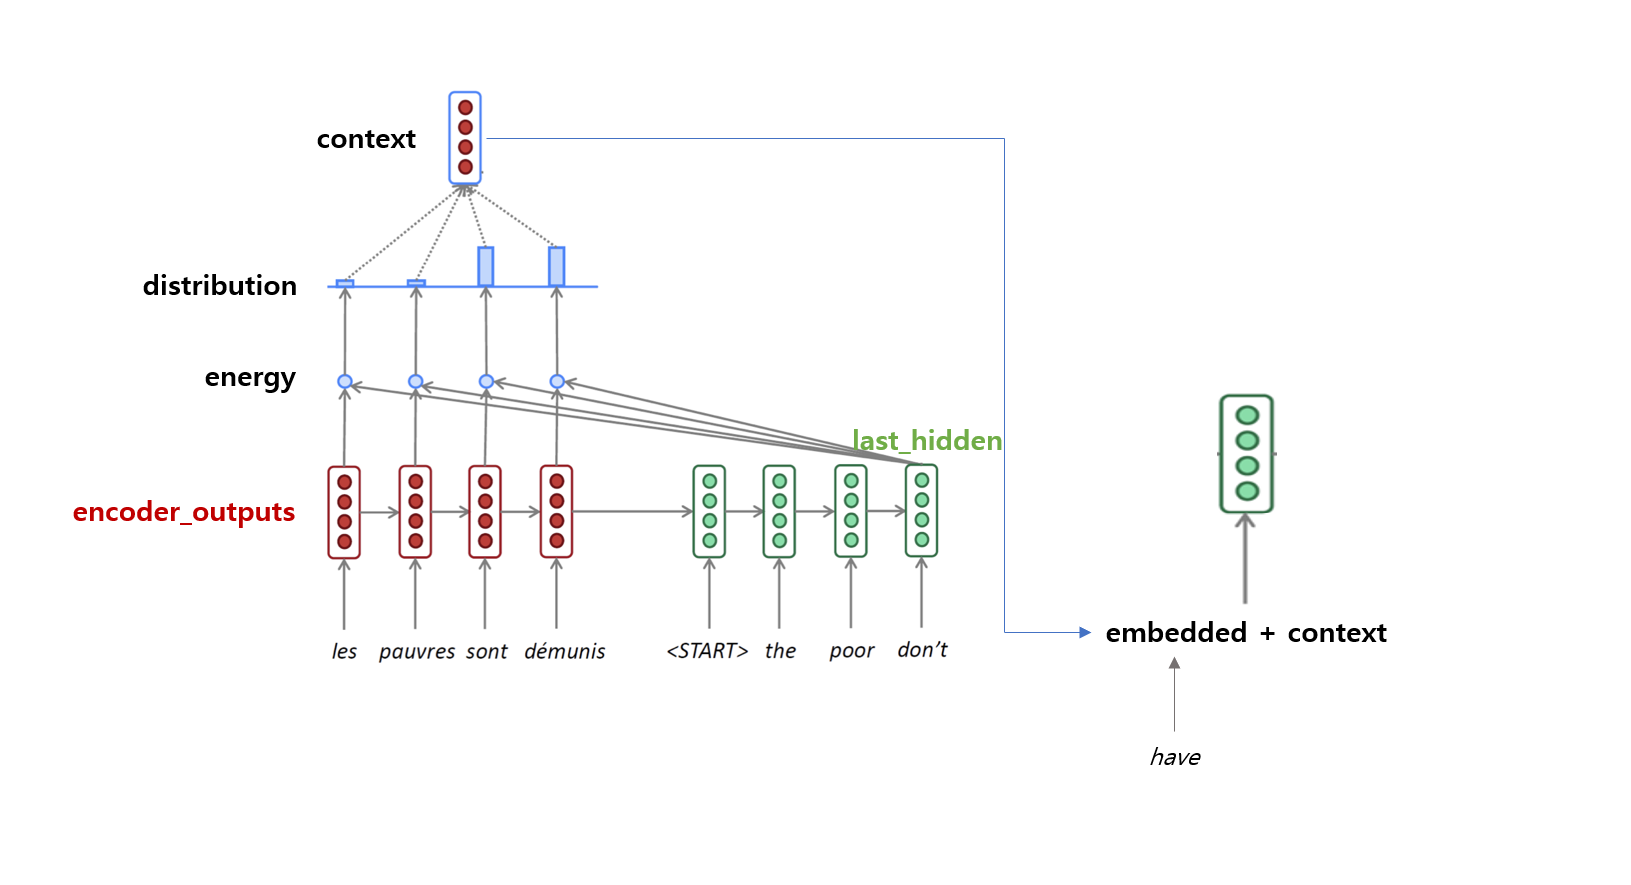

* Seq2Seq

In [46]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder 
        self.device = device 
        
    def forward(self, src, trg, teacher_forcing_ration=1):
        #encoder
        enc_output, last_hidden, = self.encoder(src)

        #decoder
        max_len, batch_size = trg.size()
        trg_vocab_size = self.decoder.output_size
        dec_outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device)
        input = trg[0, :] #[BOS]
        for t in range(1, max_len):
            output, hidden = self.decoder(input, last_hidden, enc_output)
            dec_outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ration
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1 
            last_hidden = hidden
        return dec_outputs
        
        """
        src = (max_len, batch_size)
        trg = (max_len, batch_size)
        enc_output = (max_len, batch_size, hidden_size)
        last_hidden = (num_layers, batch_size, hidden_size)
        input = (batch_size)     
        output = (batch_size, output_size)
        hidden = (num_layers, batch_size, hidden_size)
        dec_outputs = (max_len, batch_size, trg_vocab_size)
        """

* Encoder

In [47]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        output, hidden = self.gru(embedded)
        return output, hidden
        """
        src = (max_len, batch_size)
        embeded = (max_len, batch_size, embedding_size)
        output = (max_len, batch_size, hidden_size)
        hidden = (num_layers, batch_size, hidden_size)
        """

* Decoder

In [48]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers, dropout):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.gru = nn.GRU(embedding_size+hidden_size, hidden_size, num_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, trg, last_hidden, encoder_outputs):
        input = trg.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        distribution = self.attention(last_hidden[-1], encoder_outputs)
        context = distribution.bmm(encoder_outputs.transpose(0, 1)).transpose(0, 1)
        rnn_input = torch.cat([embedded, context], 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        output = output.squeeze(0)
        prediction = self.fc(output)
        return prediction, hidden
        """
        trg = (batch_size)
        last_hidden = (num_layers, batch_size, hidden_size)
        encoder_outputs = (max_len, batch_size, hidden_size)

        input = (1, batch_size)
        embeded = (1, batch_size, embedding_size)
        distribution = (batch_size, 1, max_len)
        context = (1, batch_size, hidden_size)
        rnn_input = (1, batch_size, hidden_size + embedding_size)
        output = (1, batch_size, hidden_size)
        hidden = (num_layers, batch_size, hidden_size)
        prediction = (batch_size, output_size)
        """  

* Attention

In [49]:

          
class Attention(nn.Module):

    def __init__(self, hidden_size):  
        super(Attention, self).__init__()
        self.attn_linear = nn.Linear(hidden_size*2, hidden_size)
        
    def dot_product_attention(self, hidden, encoder_output):
      
        encoder_output = encoder_output.transpose(0, 1)
        hidden = hidden.unsqueeze(1).transpose(1, 2)
        energy = torch.bmm(encoder_output, hidden).squeeze()
        return energy
        """
        encoder_output = (max_len, batch_size, hidden_size) ->  (batch_size, max_len, hidden_size)
        hidden = (batch_size, hidden_size) ->  (batch_size,hidden_size, 1) 
        energy = (batch_size, max_len)
        """
    
    
    def forward(self, hidden, encoder_outputs):
        energy = self.dot_product_attention(hidden, encoder_outputs)
        distribution = F.softmax(energy, dim=1).unsqueeze(1)
        return distribution

        """
        hidden = (batch_size, hidden_size)
        encoder_outputs = (max_len, batch_size, hidden_size) 
        energy = (batch_size, max_len)
        distribution = (batch_size, 1, max_len)
        """



In [50]:

enc = Encoder(src_vocab_size, embedding_size, hidden_size, num_layers, dropout).to(device)
dec = Decoder(trg_vocab_size, embedding_size, hidden_size, num_layers, dropout).to(device)
model = Seq2Seq(enc, dec, device).to(device)

**6. 모델 훈련(Training)**

In [51]:


#training 준비 
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss(ignore_index = pad[0]).to(device)


model.train()
for e in range(1, epochs+1):
    train_loss = 0.0
    for src, trg in tqdm(train_dataloader):  
        optimizer.zero_grad()
        src = src.to(device)
        trg = trg.to(device)
        src, trg = src.t(), trg.t()
        output = model(src, trg)
        preds = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].contiguous().view(-1)
        loss = criterion(preds, trg)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"[{e}/{epochs}] train loss: {train_loss/len(train_dataloader):.3f}") 



  0%|          | 0/782 [00:00<?, ?it/s]

[1/10] train loss: 6.543


  0%|          | 0/782 [00:00<?, ?it/s]

[2/10] train loss: 6.319


  0%|          | 0/782 [00:00<?, ?it/s]

[3/10] train loss: 6.299


  0%|          | 0/782 [00:00<?, ?it/s]

[4/10] train loss: 6.290


  0%|          | 0/782 [00:00<?, ?it/s]

[5/10] train loss: 6.304


  0%|          | 0/782 [00:00<?, ?it/s]

[6/10] train loss: 6.284


  0%|          | 0/782 [00:00<?, ?it/s]

[7/10] train loss: 6.279


  0%|          | 0/782 [00:00<?, ?it/s]

[8/10] train loss: 6.275


  0%|          | 0/782 [00:00<?, ?it/s]

[9/10] train loss: 6.275


  0%|          | 0/782 [00:00<?, ?it/s]

[10/10] train loss: 6.252


**6. 모델 훈련(Test)**


In [52]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for idx, (src, trg) in enumerate(tqdm(test_dataloader)):
        src = src.to(device)
        trg = trg.to(device)
        if idx % 500 == 0:
            print("input:", src_tokenizer.decode(list(src[0])))
            print("trg:", trg_tokenizer.decode(list(trg[0])))
        src, trg = src.t(), trg.t()
        output = model(src, trg, 0)
        preds = output[1:].view(-1, output.shape[-1])
        trgs = trg[1:].contiguous().view(-1)
        loss = criterion(preds, trgs)
        test_loss += loss.item()
        if idx % 500 == 0:
            output = output.transpose(0, 1)
            output =  output.argmax(dim=-1)
            print("preds:", trg_tokenizer.decode(list(output[0])) )
print(f"Test loss:{test_loss/len(test_dataloader.dataset)}" )  

  0%|          | 0/157 [00:00<?, ?it/s]

input: 산란된 신호는 수신 광학 채널에 의해 선택되고, 이후에, 하나 이상의 검출기에 제공된다.
trg: the scattered signal is selected by the receiving optical channel and then provided to one or more detectors.
preds: the, the, the the the the the the the the the the the the the...........
Test loss:0.09817239747047424
